# Analysis

## env vars

In [7]:
from dotenv import load_dotenv
import os

# Load .env file
load_dotenv()

# Get client ID and secret
client_id = os.getenv('CLIENT_ID')
client_secret = os.getenv('CLIENT_SECRET')

## input data

In [10]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth

# Set your credentials and the required scope
sp = spotipy.Spotify(
    auth_manager=SpotifyOAuth(
        client_id,
        client_secret,
        redirect_uri="http://localhost:3000",
        scope="playlist-read-private",
    )
)

In [45]:
import pandas as pd

# Get user's playlists
playlists = sp.current_user_playlists()

# Get the tracks from the playlists in the "Rated" folder
tracks = []
for playlist in playlists['items']:
    if playlist['name'] in ["0.0", "0.5", "1.0", "1.5", "2.0", "2.5", "3.0", "3.5", "4.0", "4.5", "5.0"]:
        playlist_id = playlist['id']
        results = sp.playlist_tracks(playlist_id)
        for item in results['items']:
            track = item['track']
            # Get audio features for each track
            audio_features = sp.audio_features(track['id'])[0]
            # Merge track and its audio features
            track.update(audio_features)
            # Add rating to track
            track['rating'] = float(playlist['name'])  # Convert the playlist name to float and use it as the rating
            tracks.append(track)
        print(f"Playlist {playlist['name']} done")

# save tracks to csv
df = pd.DataFrame(tracks)
df.to_csv('rated.csv')

Playlist 1.0 done
Playlist 1.5 done
Playlist 5.0 done
Playlist 2.5 done
Playlist 2.0 done
Playlist 0.5 done
Playlist 3.0 done
Playlist 4.5 done
Playlist 4.0 done
Playlist 3.5 done


## output data

In [94]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Load data
tracks_df = pd.read_csv('rated.csv')

# Preprocess data
tracks_df = tracks_df.dropna()  # Drop rows with missing values
tracks_df = pd.get_dummies(tracks_df)  # One-hot encode categorical data

# Define your target variable
target = 'rating'  # Replace this with the column that represents the rating of a track

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    tracks_df.drop(target, axis=1), tracks_df[target], test_size=0.2
)

# Train model
model = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=2)
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

## error

In [95]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Make predictions
predictions = model.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2 Score): {r2}')

Mean Absolute Error (MAE): 0.03156716417910448
Mean Squared Error (MSE): 0.03454514925373133
R-squared (R2 Score): 0.8822974003795067


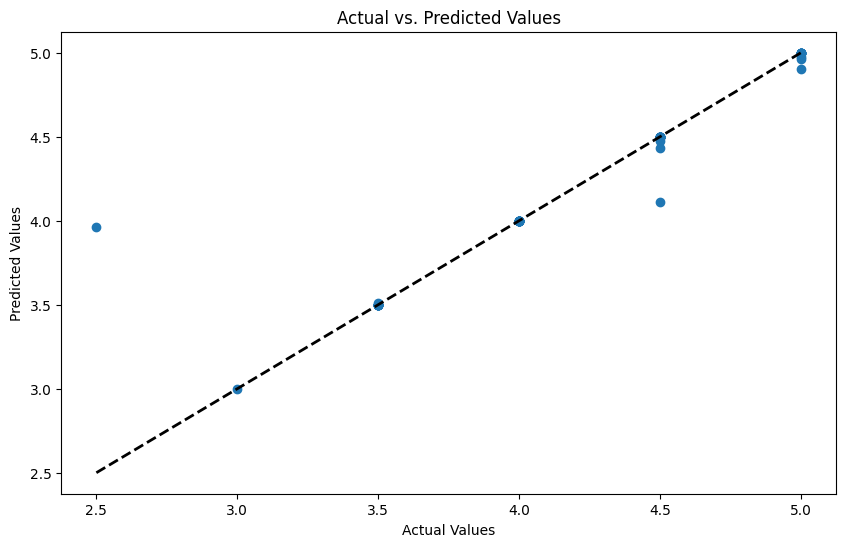

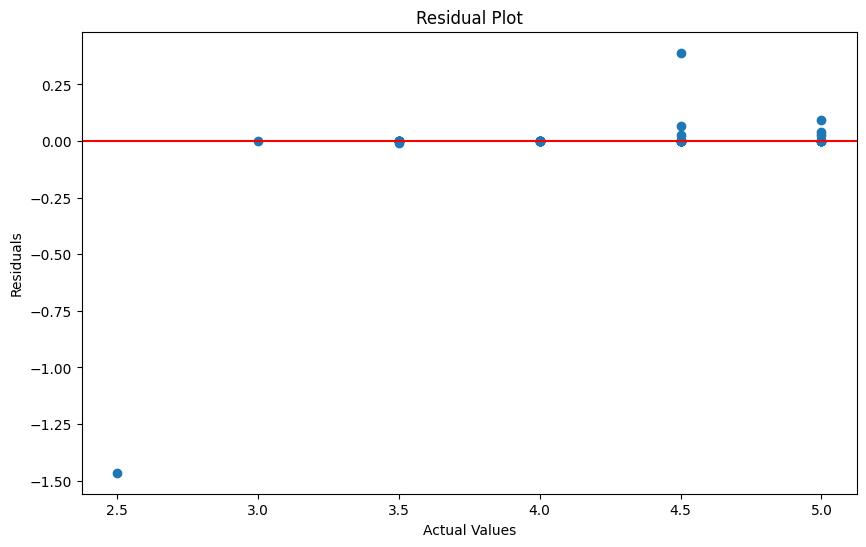

In [96]:
import matplotlib.pyplot as plt

# Make predictions
predictions = model.predict(X_test)

# Scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')

# Add y=x line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

plt.show()

# Residual plot
residuals = y_test - predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals)
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

# Give Recommendations to Users Based on Their Preferences

## load unrated songs

In [105]:
sources_ids = [
    "37i9dQZEVXcToZ9oox3nki",
    "37i9dQZF1DWZdLqpoFOt65",
    "37i9dQZEVXbn0l6flXloCt",
    "37i9dQZF1DWW1yuCSjnKtM",
    "22mm5J4DcucnRDLv0BAvti",
    "1h419AHuvIuFXjUjndFC25",
]
# discover weekly, for you., release radar, !!!, discover weekly (cash), discovered weekly (trending.)

In [106]:
import os
import pandas as pd

# Load rated songs
rated_songs = pd.read_csv('rated.csv') if os.path.exists('rated.csv') and os.path.getsize('rated.csv') > 0 else pd.DataFrame()

# Load unrated songs if exists
unrated_songs = pd.read_csv('unrated_songs.csv') if os.path.exists('unrated_songs.csv') and os.path.getsize('unrated_songs.csv') > 0 else pd.DataFrame()

tracks = []

for playlist_id in sources_ids:
    results = sp.playlist(playlist_id)

    for item in results["tracks"]["items"]:
        track = item["track"]
        
        # Skip if the track is None or if 'id' key doesn't exist in track
        if track is None or 'id' not in track:
            continue
        
        # Skip if 'id' is in the rated songs or unrated songs
        if 'id' in rated_songs.columns and track['id'] in rated_songs['id'].values:
            continue
        if 'id' in unrated_songs.columns and track['id'] in unrated_songs['id'].values:
            continue
        
        # Get audio features for each track
        audio_features = sp.audio_features(track["id"])[0]
        
        # Append track details and audio features to the list
        tracks.append({
            'id': track['id'],
            'name': track['name'],
            'artist': track['artists'][0]['name'],
            'album': track['album']['name'],
            'release_date': track['album']['release_date'],
            'duration_ms': track['duration_ms'],
            'popularity': track['popularity'],
            **audio_features
        })
        print(f"Processed {len(tracks)} tracks", end="\r")

# Convert to DataFrame and save to CSV
tracks_df = pd.DataFrame(tracks)
tracks_df.to_csv("unrated_songs.csv", index=False)

Max Retries reached


SpotifyException: http status: 429, code:-1 - /v1/audio-features/?ids=3GIChxHmuLmBm5PTNZGDtj:
 Max Retries, reason: too many 429 error responses

## recommend songs

In [ ]:
# Set display options
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', 199)  # or 199

# Load data of unrated songs
unrated_songs = pd.read_csv('unrated.csv')

# Keep a copy of song names, artist, album, and id
song_data = unrated_songs[["name", "artist", "album", "id"]]

# Preprocess data
unrated_songs = unrated_songs.dropna()  # Drop rows with missing values
unrated_songs = pd.get_dummies(unrated_songs.drop(["name", "artist", "album", "id"], axis=1))  # One-hot encode categorical data excluding song data

# Make sure the unrated songs data has the same columns as the training data
missing_cols = set(X_train.columns) - set(unrated_songs.columns)
missing_df = pd.DataFrame(0, index=unrated_songs.index, columns=list(missing_cols))
unrated_songs = pd.concat([unrated_songs, missing_df], axis=1)
unrated_songs = unrated_songs[X_train.columns]

# Predict ratings of unrated songs
predicted_ratings = model.predict(unrated_songs)

# Add predicted ratings and song data to unrated songs data
unrated_songs['predicted_rating'] = predicted_ratings
unrated_songs = pd.concat([unrated_songs, song_data], axis=1)

# Create Spotify link using the song's ID
unrated_songs['spotify_link'] = 'https://open.spotify.com/track/' + unrated_songs['id']

# Recommend the top 10 songs with the highest predicted ratings
recommended_songs = unrated_songs.nlargest(10, 'predicted_rating')

# Reset index and print recommended songs
recommended_songs = recommended_songs.reset_index(drop=True)

# Display the table
recommended_songs[["name", "artist", "album", "spotify_link", "predicted_rating"]]

,name,artist,album,spotify_link,predicted_rating
0,Departed,EastSideAngelo,Departed,https://open.spotify.com/track/41YSsQ2sIX5xMEclRyolB5,2.610
1,How To Never Stop Being Sad,dandelion hands,It's All In Your Head,https://open.spotify.com/track/6ZLt6fyonW1xOGMBC9vJPJ,2.605
2,My Song,Labi Siffre,"Crying, Laughing, Loving, Lying",https://open.spotify.com/track/2EQWbkcNoKPOXQtJM7nqRV,2.605
3,Falling For You,RADi,Falling For You,https://open.spotify.com/track/7JcCnbLVxSh1fAPHMSILVl,2.605
4,See You Again (feat. Kali Uchis),"Tyler, The Creator",Flower Boy,https://open.spotify.com/track/7KA4W4McWYRpgf0fWsJZWB,2.605
5,Fall in Love with You.,Montell Fish,JAMIE,https://open.spotify.com/track/4kJT7Yj6Za01KfKHjb7mZE,2.605
6,Could've Been (feat. Bryson Tiller),H.E.R.,I Used To Know Her,https://open.spotify.com/track/6oEVnWKgPqIEPc53OYDNqG,2.605
7,Pluto Projector,Rex Orange County,Pony,https://open.spotify.com/track/4EWBhKf1fOFnyMtUzACXEc,2.605
8,Lost at Sea - ANNA Remix,Rob Grant,Lost At Sea (ANNA Remix),https://open.spotify.com/track/3d1sRLMVrXnCBawEZo69bR,2.605
9,Practice,Drake,Take Care (Deluxe),https://open.spotify.com/track/0jF2AdhsalO1L7KkhK4LE5,2.605


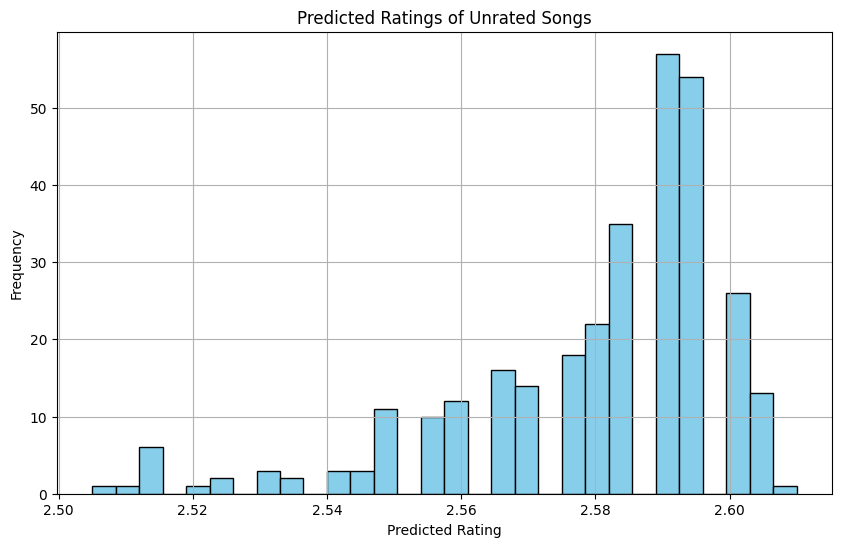

In [ ]:
# Load data of unrated songs
unrated_songs = pd.read_csv('unrated.csv')

# Keep a copy of song names, artist, album, and id
song_data = unrated_songs[["name", "artist", "album", "id"]]

# Preprocess data
unrated_songs = unrated_songs.dropna()  # Drop rows with missing values
unrated_songs = pd.get_dummies(unrated_songs.drop(["name", "artist", "album", "id"], axis=1))  # One-hot encode categorical data excluding song data

# Make sure the unrated songs data has the same columns as the training data
missing_cols = set(X_train.columns) - set(unrated_songs.columns)
missing_df = pd.DataFrame(0, index=unrated_songs.index, columns=list(missing_cols))
unrated_songs = pd.concat([unrated_songs, missing_df], axis=1)
unrated_songs = unrated_songs[X_train.columns]

# Predict ratings of unrated songs
predicted_ratings = model.predict(unrated_songs)

# Add predicted ratings and song data to unrated songs data
unrated_songs['predicted_rating'] = predicted_ratings
unrated_songs = pd.concat([unrated_songs, song_data], axis=1)

# Plot a graph of the predicted ratings
plt.figure(figsize=(10, 6))
plt.hist(unrated_songs['predicted_rating'], bins=30, color='skyblue', edgecolor='black')
plt.title('Predicted Ratings of Unrated Songs')
plt.xlabel('Predicted Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()